# **Clinical dataset**

In [1]:
# ===============================
# 1️ Imports
# ===============================
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Make plots inline
%matplotlib inline

print(" All packages imported successfully")


 All packages imported successfully


In [2]:
# ===============================
# 2️ Load Data
# ===============================
clinical    = pd.read_csv("/content/clinical.tsv", sep="\t")
exposure    = pd.read_csv("/content/exposure.tsv", sep="\t")
family      = pd.read_csv("/content/family_history.tsv", sep="\t")
follow_up   = pd.read_csv("/content/follow_up.tsv", sep="\t")
pathology   = pd.read_csv("/content/pathology_detail.tsv", sep="\t")

print("Clinical table shape:", clinical.shape)
print("Exposure table shape:", exposure.shape)
print("Family table shape:", family.shape)
print("Follow-up table shape:", follow_up.shape)
print("Pathology table shape:", pathology.shape)


Clinical table shape: (2466, 210)
Exposure table shape: (522, 40)
Family table shape: (0, 13)
Follow-up table shape: (2703, 198)
Pathology table shape: (522, 86)


In [3]:
# ===============================
# 3️ Merge tables with relevant columns
# ===============================
def select_cols(df, prefix_list):
    return df[['cases.case_id'] + [c for c in df.columns if any(c.startswith(p) for p in prefix_list)]]

clinical_small = select_cols(clinical, ['demographic.', 'diagnoses.', 'treatments.'])
exposure_small  = select_cols(exposure, ['exposures.'])
family_small    = select_cols(family, ['family_histories.'])
follow_up_small = select_cols(follow_up, ['follow_ups.'])
pathology_small = select_cols(pathology, ['pathology_details.'])

clinical_full = clinical_small.merge(exposure_small, on='cases.case_id', how='left') \
                             .merge(family_small, on='cases.case_id', how='left') \
                             .merge(follow_up_small, on='cases.case_id', how='left') \
                             .merge(pathology_small, on='cases.case_id', how='left')

print("Merged clinical table shape:", clinical_full.shape)
clinical_full.head(3)


Merged clinical table shape: (13886, 415)


,cases.case_id,demographic.age_at_index,demographic.age_is_obfuscated,demographic.cause_of_death,demographic.cause_of_death_source,demographic.country_of_birth,demographic.country_of_residence_at_enrollment,demographic.days_to_birth,demographic.days_to_death,demographic.demographic_id,...,pathology_details.tumor_infiltrating_macrophages,pathology_details.tumor_largest_dimension_diameter,pathology_details.tumor_length_measurement,pathology_details.tumor_level_prostate,pathology_details.tumor_shape,pathology_details.tumor_thickness,pathology_details.tumor_width_measurement,pathology_details.vascular_invasion_present,pathology_details.vascular_invasion_type,pathology_details.zone_of_origin_prostate
0,0075437e-ba1a-46be-86d6-9773209a2b5e,64,false,'--,'--,'--,Germany,-23689,'--,407caae1-7c07-52e1-bca7-1e60cac760eb,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--
1,0075437e-ba1a-46be-86d6-9773209a2b5e,64,false,'--,'--,'--,Germany,-23689,'--,407caae1-7c07-52e1-bca7-1e60cac760eb,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--
2,0075437e-ba1a-46be-86d6-9773209a2b5e,64,false,'--,'--,'--,Germany,-23689,'--,407caae1-7c07-52e1-bca7-1e60cac760eb,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--


In [4]:
# ===============================
# 4️ Keep essential numeric & categorical columns
# ===============================
categorical_cols = [
    'demographic.gender', 'demographic.race', 'demographic.ethnicity',
    'demographic.vital_status', 'diagnoses.primary_diagnosis',
    'diagnoses.tumor_grade', 'diagnoses.ajcc_clinical_stage',
    'diagnoses.ajcc_pathologic_stage', 'diagnoses.metastasis_at_diagnosis',
    'treatments.treatment_type', 'treatments.regimen_or_line_of_therapy',
    'treatments.treatment_outcome', 'pathology_details.margin_status',
    'follow_ups.progression_or_recurrence'
]

numerical_cols = [
    'demographic.age_at_index', 'diagnoses.days_to_diagnosis',
    'treatments.number_of_cycles', 'treatments.days_to_treatment_start',
    'treatments.days_to_treatment_end', 'follow_ups.days_to_recurrence'
]

cols_to_keep = ['cases.case_id'] + categorical_cols + numerical_cols
clinical_clean = clinical_full[cols_to_keep].copy()

print("Clean clinical table shape:", clinical_clean.shape)
clinical_clean.head(3)


Clean clinical table shape: (13886, 21)


,cases.case_id,demographic.gender,demographic.race,demographic.ethnicity,demographic.vital_status,diagnoses.primary_diagnosis,diagnoses.tumor_grade,diagnoses.ajcc_clinical_stage,diagnoses.ajcc_pathologic_stage,diagnoses.metastasis_at_diagnosis,...,treatments.regimen_or_line_of_therapy,treatments.treatment_outcome,pathology_details.margin_status,follow_ups.progression_or_recurrence,demographic.age_at_index,diagnoses.days_to_diagnosis,treatments.number_of_cycles,treatments.days_to_treatment_start,treatments.days_to_treatment_end,follow_ups.days_to_recurrence
0,0075437e-ba1a-46be-86d6-9773209a2b5e,male,white,not hispanic or latino,Alive,"Adenocarcinoma, NOS",'--,'--,Stage IIB,'--,...,'--,Complete Response,'--,'--,64,0,'--,41,115,'--
1,0075437e-ba1a-46be-86d6-9773209a2b5e,male,white,not hispanic or latino,Alive,"Adenocarcinoma, NOS",'--,'--,Stage IIB,'--,...,'--,Complete Response,'--,'--,64,0,'--,41,115,'--
2,0075437e-ba1a-46be-86d6-9773209a2b5e,male,white,not hispanic or latino,Alive,"Adenocarcinoma, NOS",'--,'--,Stage IIB,'--,...,'--,Complete Response,'--,'--,64,0,'--,41,115,'--


In [5]:
# ===============================
# 5️ Encode categorical columns
# ===============================
for col in categorical_cols:
    clinical_clean[col] = clinical_clean[col].fillna('Unknown')
    le = LabelEncoder()
    clinical_clean[col] = le.fit_transform(clinical_clean[col])

print(" Categorical columns encoded")
clinical_clean[categorical_cols].head(3)


 Categorical columns encoded


,demographic.gender,demographic.race,demographic.ethnicity,demographic.vital_status,diagnoses.primary_diagnosis,diagnoses.tumor_grade,diagnoses.ajcc_clinical_stage,diagnoses.ajcc_pathologic_stage,diagnoses.metastasis_at_diagnosis,treatments.treatment_type,treatments.regimen_or_line_of_therapy,treatments.treatment_outcome,pathology_details.margin_status,follow_ups.progression_or_recurrence
0,2,6,3,1,4,0,0,6,0,3,0,1,0,0
1,2,6,3,1,4,0,0,6,0,3,0,1,0,0
2,2,6,3,1,4,0,0,6,0,3,0,1,0,0


In [6]:
# ===============================
# 6️ Fill missing numerics & scale
# ===============================
for col in numerical_cols:
    clinical_clean[col] = pd.to_numeric(clinical_clean[col], errors='coerce')
    clinical_clean[col] = clinical_clean[col].fillna(clinical_clean[col].median())

scaler = StandardScaler()
clinical_clean[numerical_cols] = scaler.fit_transform(clinical_clean[numerical_cols])

print("Numeric columns scaled")
clinical_clean[numerical_cols].head(3)


Numeric columns scaled


,demographic.age_at_index,diagnoses.days_to_diagnosis,treatments.number_of_cycles,treatments.days_to_treatment_start,treatments.days_to_treatment_end,follow_ups.days_to_recurrence
0,-0.133235,-0.338607,-0.014986,-0.386171,-0.642133,-0.067117
1,-0.133235,-0.338607,-0.014986,-0.386171,-0.642133,-0.067117
2,-0.133235,-0.338607,-0.014986,-0.386171,-0.642133,-0.067117


In [7]:
# ===============================
# 7️ Prepare X and y
# ===============================
X = clinical_clean.drop(columns=['cases.case_id', 'diagnoses.primary_diagnosis'])
y = clinical_clean['diagnoses.primary_diagnosis']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Class distribution:", Counter(y))


Features shape: (13886, 19)
Target shape: (13886,)
Class distribution: Counter({4: 6750, 25: 2134, 3: 2124, 26: 590, 2: 550, 24: 500, 8: 352, 34: 104, 5: 88, 17: 77, 33: 66, 19: 65, 0: 63, 6: 50, 14: 34, 28: 34, 7: 33, 23: 33, 9: 24, 18: 21, 12: 20, 1: 18, 22: 18, 13: 18, 21: 16, 29: 14, 20: 10, 30: 10, 11: 10, 16: 10, 15: 10, 31: 10, 27: 8, 32: 8, 35: 8, 10: 6})


In [8]:
# ===============================
# 8️ Train XGBoost
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

xgb_clf = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False,
    tree_method='hist'
)

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, zero_division=0))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:26:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9464
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         4
           2       0.97      0.94      0.95       110
           3       0.94      0.91      0.93       425
           4       0.96      0.98      0.97      1350
           5       0.76      0.72      0.74        18
           6       1.00      0.80      0.89        10
           7       1.00      0.86      0.92         7
           8       0.93      0.91      0.92        70
           9       1.00      0.60      0.75         5
          10       1.00      1.00      1.00         1
          11       0.00      0.00      0.00         2
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         7
          15       0.50      1.00      0.67         2
          16       1.00      1.00      1.00         2
  

Top 15 Important Features:
treatments.number_of_cycles: 0.1303
diagnoses.days_to_diagnosis: 0.1162
diagnoses.ajcc_pathologic_stage: 0.0948
treatments.days_to_treatment_end: 0.0791
demographic.race: 0.0771
demographic.ethnicity: 0.0750
treatments.treatment_outcome: 0.0747
treatments.days_to_treatment_start: 0.0735
demographic.gender: 0.0729
demographic.age_at_index: 0.0673
follow_ups.days_to_recurrence: 0.0610
demographic.vital_status: 0.0562
treatments.treatment_type: 0.0122
follow_ups.progression_or_recurrence: 0.0097
diagnoses.tumor_grade: 0.0000


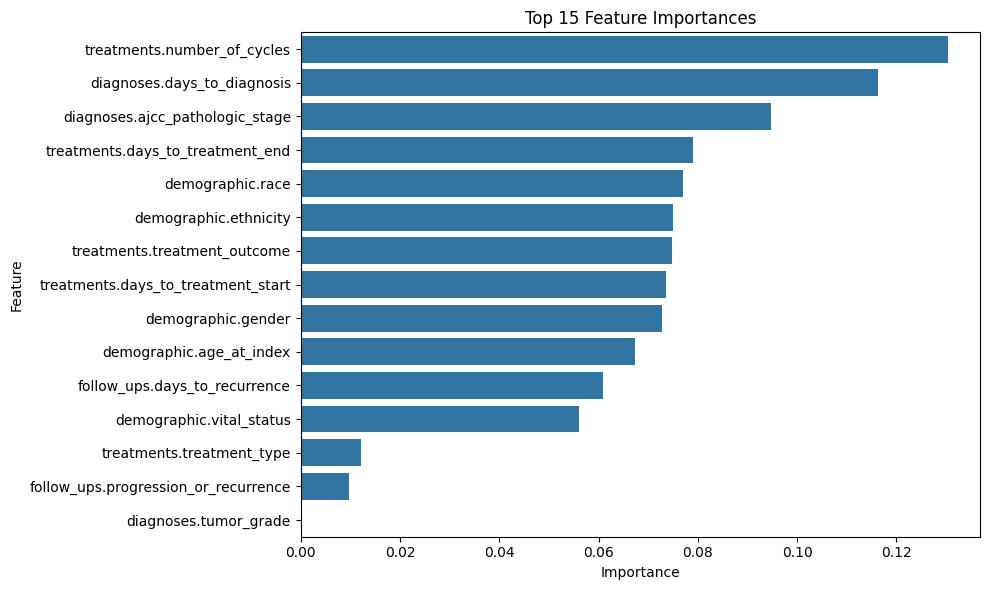

In [9]:
# ===============================
# 9️ Feature Importance
# ===============================
feat_importance = sorted(zip(X.columns, xgb_clf.feature_importances_), key=lambda x: x[1], reverse=True)
print("Top 15 Important Features:")
for f, imp in feat_importance[:15]:
    print(f"{f}: {imp:.4f}")

plt.figure(figsize=(10,6))
sns.barplot(x=[imp for _, imp in feat_importance[:15]], y=[f for f, _ in feat_importance[:15]])
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [10]:
# ===============================
# 10 Ensemble: XGBoost + RandomForest
# ===============================
rf_clf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=42)
ensemble = VotingClassifier(estimators=[('xgb', xgb_clf), ('rf', rf_clf)], voting='soft')
ensemble.fit(X_train, y_train)

y_pred_ensemble = ensemble.predict(X_test)
print(f"Ensemble Accuracy: {accuracy_score(y_test, y_pred_ensemble):.4f}")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble Accuracy: 0.9374


Diagnosis distribution in dataset:
diagnoses.primary_diagnosis
4     6750
25    2134
3     2124
26     590
2      550
24     500
8      352
34     104
5       88
17      77
33      66
19      65
0       63
6       50
28      34
14      34
7       33
23      33
9       24
18      21
12      20
13      18
1       18
22      18
21      16
29      14
31      10
20      10
15      10
30      10
11      10
16      10
32       8
27       8
35       8
10       6
Name: count, dtype: int64


/tmp/ipython-input-2859770334.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=diagnosis_counts.index, y=diagnosis_counts.values, palette="coolwarm")


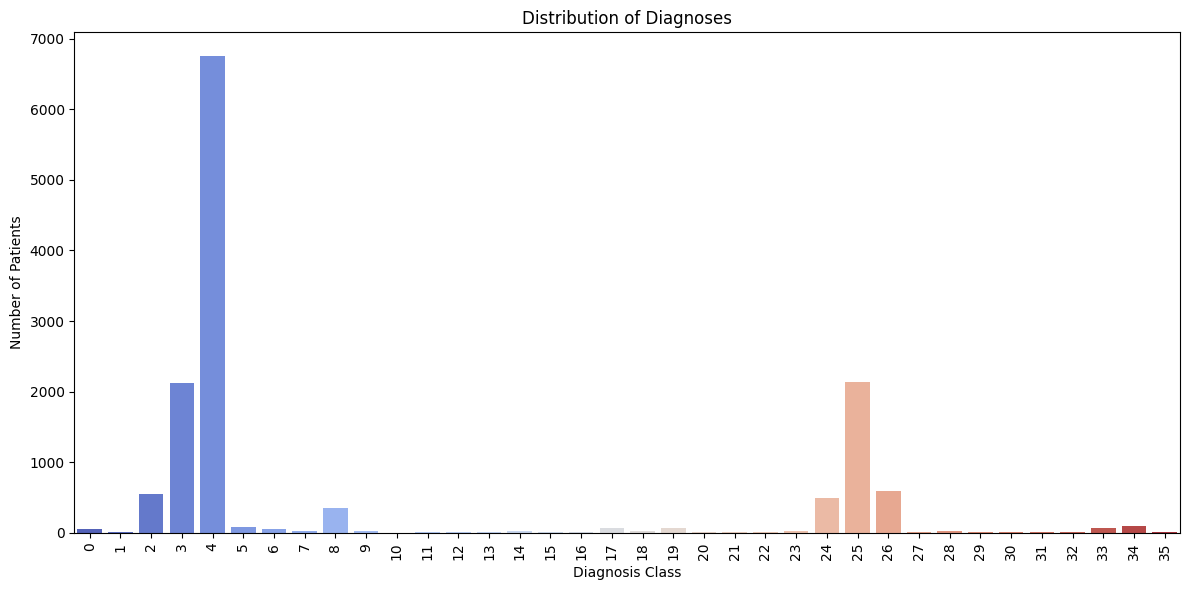


Prognosis / Recurrence distribution:
diagnoses.progression_or_recurrence
'--    2466
Name: count, dtype: int64


/tmp/ipython-input-2859770334.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prognosis_counts.index, y=prognosis_counts.values, palette="magma")


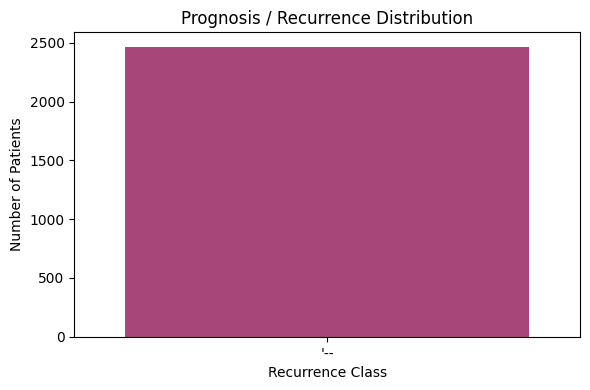


Treatment outcome distribution:
treatments.treatment_outcome
'--                    2074
Complete Response       152
Progressive Disease      98
Treatment Ongoing        42
Stable Disease           40
Unknown                  35
Partial Response         25
Name: count, dtype: int64


/tmp/ipython-input-2859770334.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=treatment_counts.index, y=treatment_counts.values, palette="viridis")


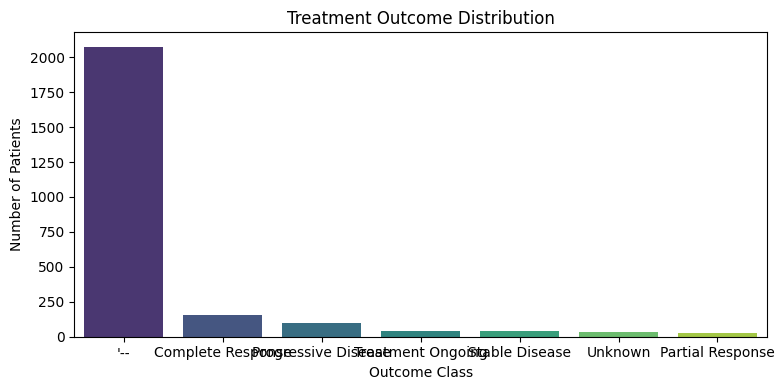

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 1️ Diagnosis Distribution
# ===============================
if 'diagnoses.primary_diagnosis' in clinical_clean.columns:
    diagnosis_counts = clinical_clean['diagnoses.primary_diagnosis'].value_counts()
    print("Diagnosis distribution in dataset:")
    print(diagnosis_counts)

    plt.figure(figsize=(12,6))
    sns.barplot(x=diagnosis_counts.index, y=diagnosis_counts.values, palette="coolwarm")
    plt.xticks(rotation=90)
    plt.title("Distribution of Diagnoses")
    plt.xlabel("Diagnosis Class")
    plt.ylabel("Number of Patients")
    plt.tight_layout()
    plt.show()

# ===============================
# 2️ Prognosis / Recurrence Distribution
# ===============================
prognosis_col = 'diagnoses.progression_or_recurrence'
if prognosis_col in clinical.columns:
    prognosis_counts = clinical[prognosis_col].value_counts()
    print("\nPrognosis / Recurrence distribution:")
    print(prognosis_counts)

    plt.figure(figsize=(6,4))
    sns.barplot(x=prognosis_counts.index, y=prognosis_counts.values, palette="magma")
    plt.title("Prognosis / Recurrence Distribution")
    plt.xlabel("Recurrence Class")
    plt.ylabel("Number of Patients")
    plt.tight_layout()
    plt.show()

# ===============================
# 3️ Treatment Outcome Distribution
# ===============================
treatment_col = 'treatments.treatment_outcome'
if treatment_col in clinical.columns:
    treatment_counts = clinical[treatment_col].value_counts()
    print("\nTreatment outcome distribution:")
    print(treatment_counts)

    plt.figure(figsize=(8,4))
    sns.barplot(x=treatment_counts.index, y=treatment_counts.values, palette="viridis")
    plt.title("Treatment Outcome Distribution")
    plt.xlabel("Outcome Class")
    plt.ylabel("Number of Patients")
    plt.tight_layout()
    plt.show()


In [12]:
# ===============================
# 12 Predict on Test Set (Realistic Accuracy)
# ===============================
y_test_pred = xgb_clf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print(f" Test Set Accuracy: {test_acc:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, zero_division=0))

# ===============================
# 12 Predict on Whole Dataset (Final Accuracy)
# ===============================
y_full_pred = xgb_clf.predict(X)
final_acc = accuracy_score(y, y_full_pred)

print(f"\n Final Accuracy on Whole Dataset: {final_acc:.4f}")
print("\nClassification Report (Whole Dataset):")
print(classification_report(y, y_full_pred, zero_division=0))


 Test Set Accuracy: 0.9464

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         4
           2       0.97      0.94      0.95       110
           3       0.94      0.91      0.93       425
           4       0.96      0.98      0.97      1350
           5       0.76      0.72      0.74        18
           6       1.00      0.80      0.89        10
           7       1.00      0.86      0.92         7
           8       0.93      0.91      0.92        70
           9       1.00      0.60      0.75         5
          10       1.00      1.00      1.00         1
          11       0.00      0.00      0.00         2
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         7
          15       0.50      1.00      0.67         2
          16       

In [13]:
!pip install shap lime --quiet
import shap
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import numpy as np


100%|===================| 3598/3600 [33:55<00:01]       

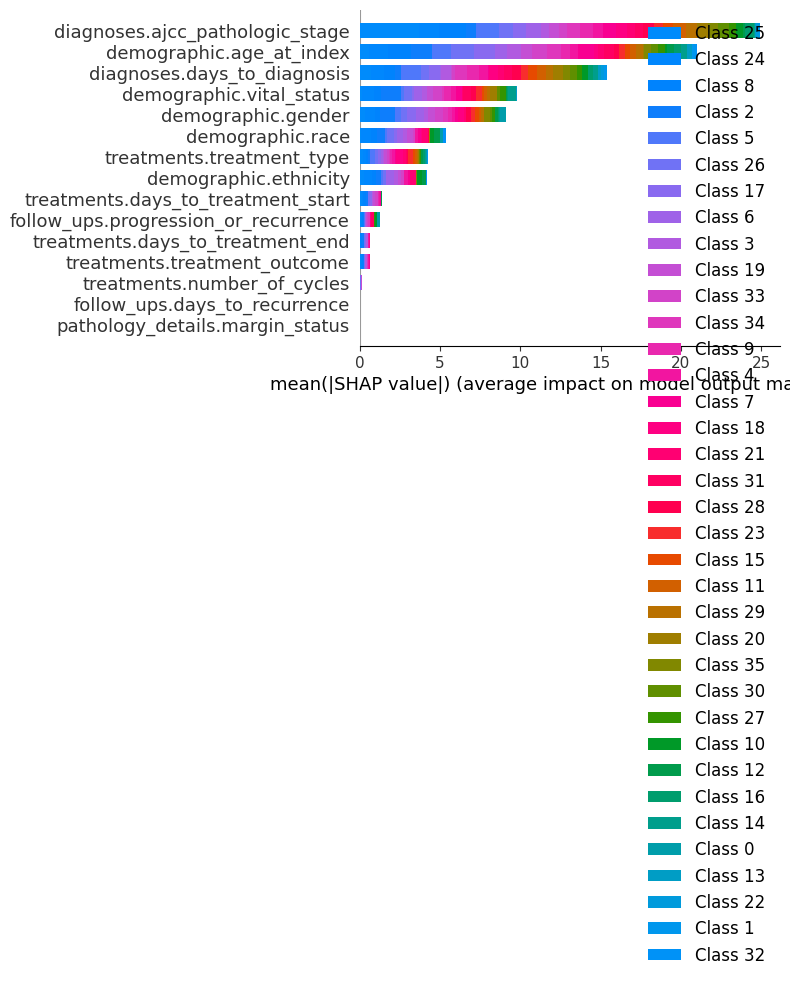

In [15]:
sample_size = 100
X_sample = X.sample(sample_size, random_state=42)

explainer_shap = shap.Explainer(xgb_clf, X_sample)
shap_values = explainer_shap(X_sample)

# Summary plot
shap.summary_plot(shap_values, X_sample, feature_names=X.columns, plot_type="bar", max_display=15)


In [16]:
# -------------------------------
# 14 LIME: Local Explanation
# -------------------------------
explainer_lime = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    class_names=[str(c) for c in np.unique(y)],
    mode="classification"
)

# Pick a random patient from test set
idx = np.random.randint(0, X_test.shape[0])
exp = explainer_lime.explain_instance(
    data_row=X_test.iloc[idx],
    predict_fn=xgb_clf.predict_proba,
    num_features=10
)

print(f"LIME explanation for patient index {idx} (true class: {y_test.iloc[idx]})")
exp.show_in_notebook(show_table=True)


/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

LIME explanation for patient index 2098 (true class: 26)


/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.